In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Paraná - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Paraná - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819425,332.705560,0.728728,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,189.804,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819770,332.945945,0.729031,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,174.713,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820115,335.222130,0.729334,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,180.801,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820460,334.785737,0.729638,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,180.172,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820805,335.050185,0.729941,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,185.597,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39310.840386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,39274.836083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,39220.898111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,39146.237796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


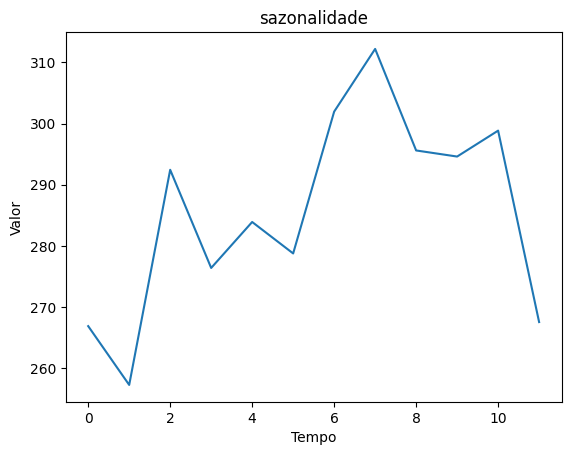

,sazonalidade
sazonalidade,
0,266.872418
1,257.260600
2,292.431378
3,276.384422
4,283.897841
5,278.755324
6,301.939056
7,312.192778
8,295.592821


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Paraná - Consumo de Cimento (t)
0,2003-1,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819425,332.705560,0.728728,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,266.872418,189.804
1,2003-2,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819770,332.945945,0.729031,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,257.260600,174.713
2,2003-3,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820115,335.222130,0.729334,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,292.431378,180.801
3,2003-4,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820460,334.785737,0.729638,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,276.384422,180.172
4,2003-5,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820805,335.050185,0.729941,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,283.897841,185.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39310.840386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.897841,NaN
245,2023-6,39274.836083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278.755324,NaN
246,2023-7,39220.898111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301.939056,NaN
247,2023-8,39146.237796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.192778,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Paraná - Consumo de Cimento (t), Length: 249, dtype: float64

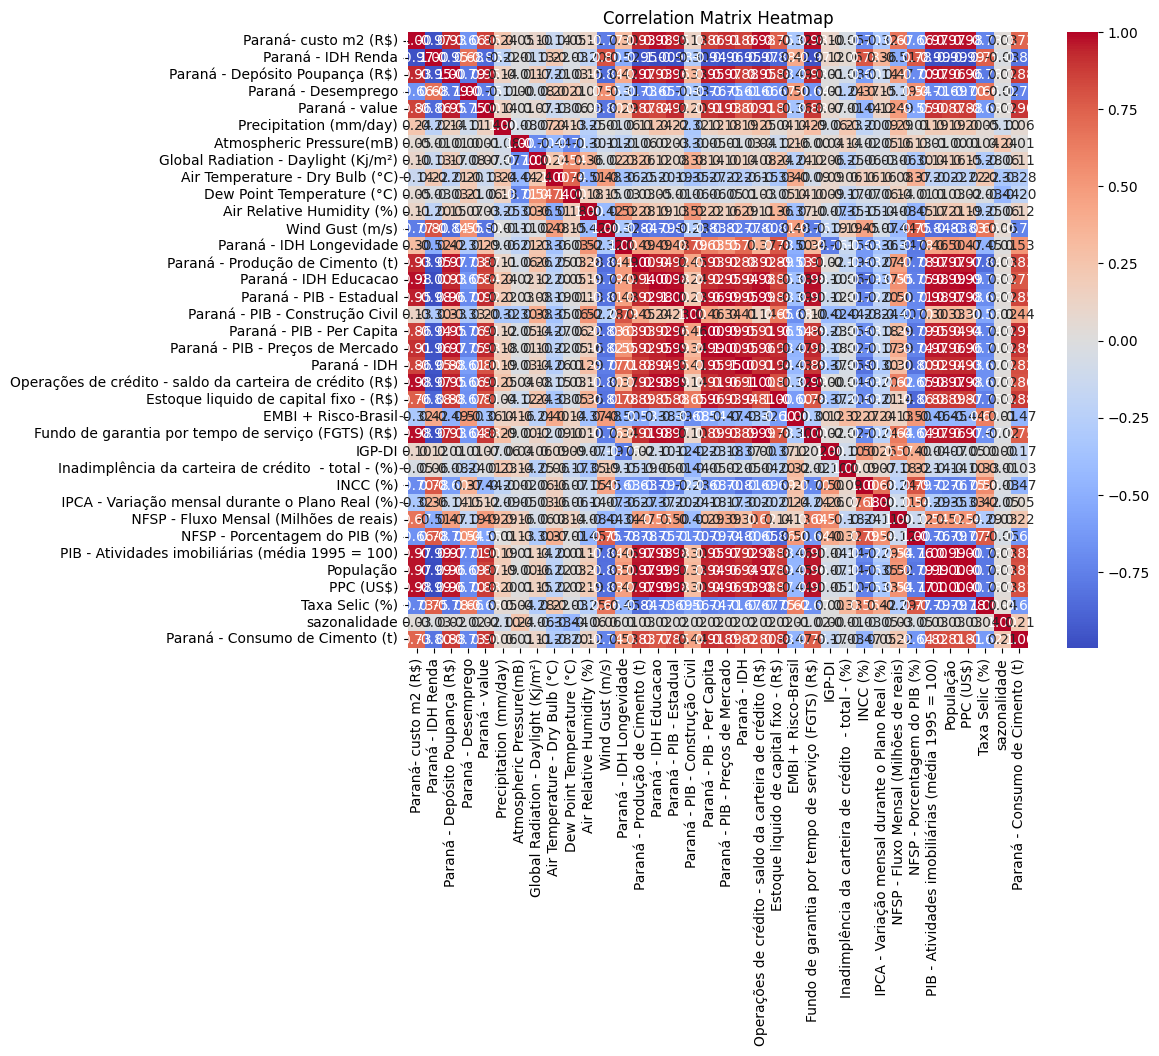

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Paraná- custo m2 (R$),9.149700e+05
1,Paraná - IDH Renda,4.212811e+04
2,Paraná - Depósito Poupança (R$),4.126961e+04
3,Paraná - Desemprego,7.288144e+04
4,Paraná - value,1.265487e+05
5,Precipitation (mm/day),8.093990e+01
6,Atmospheric Pressure(mB),1.485192e+05
7,Global Radiation - Daylight (Kj/m²),7.062148e+02
8,Air Temperature - Dry Bulb (°C),9.615060e+04
9,Dew Point Temperature (°C),5.180199e+04


In [39]:
data =data.fillna(0.0).drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 8


,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,332.705560,2.027147e+08,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,266.872418
1,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,332.945945,2.029477e+08,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,257.260600
2,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,335.222130,2.031806e+08,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,292.431378
3,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.785737,2.034136e+08,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,276.384422
4,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,335.050185,2.036466e+08,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,283.897841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,29489.365081,0.758144,2.962816e+07,7.287302,0.441774,1.828472,914.231739,1169.778066,17.463958,12.555808,73.082166,1.849609,552.046591,2.390998e+08,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,312.192778
200,29741.638927,0.758088,2.991025e+07,7.275706,0.444540,1.821088,913.211365,1214.365714,18.269268,13.362899,73.534820,1.878035,555.331410,2.388543e+08,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,295.592821
201,30001.691378,0.758031,3.019234e+07,7.264111,0.447490,1.970480,912.362227,1266.863323,19.087200,14.129068,73.576154,1.878787,559.023816,2.386088e+08,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,294.596530
202,30268.486764,0.757975,3.047444e+07,7.252516,0.451352,1.939850,911.916971,1261.970495,19.478320,14.714040,74.214416,1.817195,562.207553,2.383633e+08,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,298.834075


In [40]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data = input_data.fillna(0.0)
input_data

,Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,2.004430,-1.478824,1.260779,-1.049670,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.694447,-1.723164,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,1.978759,-1.476084,1.246551,-1.031631,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.690721,-1.706343,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,1.953088,-1.473344,1.232324,-1.016861,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.655443,-1.689521,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,1.927417,-1.470604,1.218096,-1.004729,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.662206,-1.672699,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,1.901746,-1.467864,1.203869,-0.994911,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.658108,-1.655878,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-1.222338,1.367480,-1.018397,1.181158,0.477699,0.255991,0.259641,0.041570,0.033548,0.189439,-0.219038,1.705139,0.904083,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,-1.226682,1.416119,-1.044908,1.224851,0.464092,0.251241,0.413815,0.213569,0.265767,0.214378,-0.171334,1.756051,0.886354,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,-1.231025,1.464758,-1.071418,1.271460,0.739365,0.247288,0.595339,0.388263,0.486212,0.216655,-0.170072,1.813280,0.868625,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,-1.235369,1.513396,-1.097929,1.332476,0.682925,0.245215,0.578421,0.471798,0.654523,0.251819,-0.273436,1.862625,0.850897,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,2.004430,-1.478824,1.260779,-1.049670,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.694447,-1.723164,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,1.978759,-1.476084,1.246551,-1.031631,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.690721,-1.706343,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,1.953088,-1.473344,1.232324,-1.016861,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.655443,-1.689521,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,1.927417,-1.470604,1.218096,-1.004729,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.662206,-1.672699,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,1.901746,-1.467864,1.203869,-0.994911,-2.891459,-3.999951,-3.785175,-3.688382,-3.579057,-3.836948,-3.323072,-1.658108,-1.655878,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-1.190705,1.014391,-0.764610,0.690548,-0.050421,0.252697,0.051131,-0.105646,-0.024993,0.229649,-0.225448,1.041932,1.073824,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,-1.190950,1.016914,-0.778253,0.741170,0.201381,0.249100,0.237543,0.121180,0.240304,0.207513,-0.141936,1.073196,1.064696,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,-1.191196,1.019438,-0.791895,0.778858,0.613819,0.248113,0.444665,0.364771,0.522774,0.186165,-0.087834,1.141778,1.055568,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,-1.191442,1.021962,-0.805538,0.815897,0.899961,0.246607,0.651547,0.551462,0.703135,0.147707,-0.061111,1.189070,1.046440,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
187    385.013
188    385.153
189    437.527
190    380.827
191    311.548
Name: Paraná - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 25)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,-1.233441,0.503940,0.246754,0.695053,1.452809,0.245351,0.410516,0.713199,1.092262,0.463629,0.069079,0.554883,1.144835,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,-1.231112,0.522892,0.191966,0.652672,1.531965,0.248141,0.195031,0.573033,0.950989,0.481463,-0.035019,0.554440,1.147097,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,-1.228783,0.541845,0.137177,0.616601,1.411490,0.251968,0.098533,0.278299,0.511971,0.411941,-0.179595,0.583040,1.149359,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,-1.226455,0.560797,0.082389,0.589128,1.621066,0.254503,0.011248,0.038009,0.120745,0.319322,-0.252494,0.589638,1.151621,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,-1.224126,0.579749,0.027600,0.556676,1.125076,0.256751,-0.168219,-0.252772,-0.262317,0.307465,-0.279597,0.571207,1.153883,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,-1.221797,0.598702,-0.027189,0.523943,1.109526,0.257658,0.074655,-0.354503,-0.533106,0.190668,-0.221567,0.610741,1.156145,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,-1.219469,0.617654,-0.081977,0.491518,1.286373,0.255674,0.165352,-0.307337,-0.465962,0.188330,-0.018485,0.628301,1.158407,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,-1.217140,0.636606,-0.136766,0.475528,0.958567,0.253278,0.298453,-0.237958,-0.339945,0.221338,0.082548,0.647258,1.160669,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,-1.214811,0.655559,-0.191554,0.461648,0.966202,0.250166,0.392837,-0.055136,-0.099038,0.217856,0.210573,0.660817,1.162931,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,-1.212483,0.674511,-0.246343,0.452158,1.066314,0.246906,0.377648,0.178621,0.280379,0.262524,0.231523,0.675796,1.165194,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 25)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3649013066, 889172165, 2264202371, 1672359910, 2631548098, 2483610807, 2387926600, 3586593818, 2156450788, 984649300]


Step: 0 ___________________________________________
val_loss: 1458.4583740234375
winner_seed: 3649013066


Step: 1 ___________________________________________
val_loss: 526724497408.0


Step: 2 ___________________________________________
val_loss: 390821856.0


Step: 3 ___________________________________________
val_loss: 1547.6746826171875


Step: 4 ___________________________________________
val_loss: 1632.85107421875


Step: 5 ___________________________________________
val_loss: 3684828.75


Step: 6 ___________________________________________
val_loss: 1997.5233154296875


Step: 7 ___________________________________________
val_loss: 277042944.0


Step: 8 ___________________________________________
val_loss: 1897.0653076171875


Step: 9 ___________________________________________
val_loss: 1352.242431640625
winner_seed: 984649300


final_seed: 984649300


In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 104ms/step - loss: 71233.6562 - val_loss: 2060.5752
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 2665.9604 - val_loss: 2025.7554
Epoch 3/10000
5/5 [==============================] - 0s 9ms/step - loss: 2794.2480 - val_loss: 1808.5724
Epoch 4/10000
5/5 [==============================] - 0s 9ms/step - loss: 2871.6536 - val_loss: 1822.3029
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 2647.8679 - val_loss: 1852.4442
Epoch 6/10000
5/5 [==============================] - 0s 10ms/step - loss: 2801.4851 - val_loss: 5054.1133
Epoch 7/10000
5/5 [==============================] - 0s 10ms/step - loss: 3461.4302 - val_loss: 1825.9719
Epoch 8/10000
5/5 [==============================] - 0s 9ms/step - loss: 2654.1460 - val_loss: 1815.2001
Epoch 9/10000
5/5 [==============================] - 0s 10ms/step - loss: 2612.0964 - val_loss: 1808.9930
Epoch 10/10000
5/5 [===========================

Epoch 78/10000
5/5 [==============================] - 0s 11ms/step - loss: 1121.3965 - val_loss: 1830.9962
Epoch 79/10000
5/5 [==============================] - 0s 10ms/step - loss: 1196.4623 - val_loss: 2469.7773
Epoch 80/10000
5/5 [==============================] - 0s 10ms/step - loss: 858.5096 - val_loss: 2226.3291
Epoch 81/10000
5/5 [==============================] - 0s 10ms/step - loss: 795.5797 - val_loss: 3416.2134
Epoch 82/10000
5/5 [==============================] - 0s 10ms/step - loss: 876.5798 - val_loss: 2318.9312
Epoch 83/10000
5/5 [==============================] - 0s 10ms/step - loss: 790.6144 - val_loss: 1911.9902
Epoch 84/10000
5/5 [==============================] - 0s 10ms/step - loss: 751.2510 - val_loss: 1929.9536
Epoch 85/10000
5/5 [==============================] - 0s 10ms/step - loss: 846.1776 - val_loss: 1891.0151
Epoch 86/10000
5/5 [==============================] - 0s 9ms/step - loss: 949.1600 - val_loss: 2140.0869
Epoch 87/10000
5/5 [=========================

Epoch 155/10000
5/5 [==============================] - 0s 11ms/step - loss: 613.8772 - val_loss: 2670.9363
Epoch 156/10000
5/5 [==============================] - 0s 10ms/step - loss: 851.5843 - val_loss: 2012.4492
Epoch 157/10000
5/5 [==============================] - 0s 10ms/step - loss: 752.6231 - val_loss: 1979.1991
Epoch 158/10000
5/5 [==============================] - 0s 10ms/step - loss: 697.9584 - val_loss: 3083.2874
Epoch 159/10000
5/5 [==============================] - 0s 12ms/step - loss: 708.5598 - val_loss: 4377.2944
Epoch 160/10000
5/5 [==============================] - 0s 9ms/step - loss: 722.4362 - val_loss: 2350.8232
Epoch 161/10000
5/5 [==============================] - 0s 11ms/step - loss: 787.6995 - val_loss: 2697.0374
Epoch 162/10000
5/5 [==============================] - 0s 11ms/step - loss: 624.6770 - val_loss: 1901.5887
Epoch 163/10000
5/5 [==============================] - 0s 10ms/step - loss: 812.5206 - val_loss: 1979.7749
Epoch 164/10000
5/5 [=================

5/5 [==============================] - 0s 11ms/step - loss: 703.2866 - val_loss: 1758.8540
Epoch 232/10000
5/5 [==============================] - 0s 10ms/step - loss: 612.6761 - val_loss: 2222.7935
Epoch 233/10000
5/5 [==============================] - 0s 10ms/step - loss: 606.3912 - val_loss: 2229.8691
Epoch 234/10000
5/5 [==============================] - 0s 9ms/step - loss: 617.7176 - val_loss: 2246.3552
Epoch 235/10000
5/5 [==============================] - 0s 10ms/step - loss: 598.9783 - val_loss: 1698.4819
Epoch 236/10000
5/5 [==============================] - 0s 10ms/step - loss: 601.2283 - val_loss: 1597.8320
Epoch 237/10000
5/5 [==============================] - 0s 10ms/step - loss: 690.0107 - val_loss: 2113.8862
Epoch 238/10000
5/5 [==============================] - 0s 11ms/step - loss: 543.8033 - val_loss: 1753.8516
Epoch 239/10000
5/5 [==============================] - 0s 10ms/step - loss: 499.3308 - val_loss: 1702.5031
Epoch 240/10000
5/5 [==============================] -

Epoch 308/10000
5/5 [==============================] - 0s 10ms/step - loss: 853.1788 - val_loss: 1791.8556
Epoch 309/10000
5/5 [==============================] - 0s 10ms/step - loss: 501.6749 - val_loss: 2548.8721
Epoch 310/10000
5/5 [==============================] - 0s 10ms/step - loss: 515.5591 - val_loss: 1661.4536
Epoch 311/10000
5/5 [==============================] - 0s 10ms/step - loss: 533.3730 - val_loss: 2317.6287
Epoch 312/10000
5/5 [==============================] - 0s 10ms/step - loss: 558.1453 - val_loss: 1812.8224
Epoch 313/10000
5/5 [==============================] - 0s 10ms/step - loss: 468.8457 - val_loss: 1555.2921
Epoch 314/10000
5/5 [==============================] - 0s 10ms/step - loss: 450.1057 - val_loss: 2596.4446
Epoch 315/10000
5/5 [==============================] - 0s 10ms/step - loss: 556.9517 - val_loss: 1586.6707
Epoch 316/10000
5/5 [==============================] - 0s 10ms/step - loss: 490.8354 - val_loss: 1812.0927
Epoch 317/10000
5/5 [================

5/5 [==============================] - 0s 10ms/step - loss: 543.4771 - val_loss: 1851.2518
Epoch 385/10000
5/5 [==============================] - 0s 10ms/step - loss: 621.6491 - val_loss: 2119.0413
Epoch 386/10000
5/5 [==============================] - 0s 9ms/step - loss: 604.6877 - val_loss: 2678.6079
Epoch 387/10000
5/5 [==============================] - 0s 9ms/step - loss: 487.8194 - val_loss: 1739.2567
Epoch 388/10000
5/5 [==============================] - 0s 9ms/step - loss: 574.1837 - val_loss: 1941.1359
Epoch 389/10000
5/5 [==============================] - 0s 9ms/step - loss: 602.6282 - val_loss: 2871.9021
Epoch 390/10000
5/5 [==============================] - 0s 10ms/step - loss: 551.2010 - val_loss: 2069.8633
Epoch 391/10000
5/5 [==============================] - 0s 10ms/step - loss: 600.5280 - val_loss: 1951.3927
Epoch 392/10000
5/5 [==============================] - 0s 10ms/step - loss: 563.9148 - val_loss: 2089.7200
Epoch 393/10000
5/5 [==============================] - 0s

Epoch 461/10000
5/5 [==============================] - 0s 9ms/step - loss: 463.5602 - val_loss: 2251.3611
Epoch 462/10000
5/5 [==============================] - 0s 8ms/step - loss: 425.2008 - val_loss: 2186.4707
Epoch 463/10000
5/5 [==============================] - 0s 9ms/step - loss: 482.6677 - val_loss: 1886.4917
Epoch 464/10000
5/5 [==============================] - 0s 9ms/step - loss: 569.3260 - val_loss: 2275.6299
Epoch 465/10000
5/5 [==============================] - 0s 8ms/step - loss: 449.6797 - val_loss: 1975.0526
Epoch 466/10000
5/5 [==============================] - 0s 9ms/step - loss: 507.8710 - val_loss: 2243.4219
Epoch 467/10000
5/5 [==============================] - 0s 9ms/step - loss: 421.7283 - val_loss: 2000.1368
Epoch 468/10000
5/5 [==============================] - 0s 11ms/step - loss: 435.0502 - val_loss: 2017.7358
Epoch 469/10000
5/5 [==============================] - 0s 9ms/step - loss: 444.6109 - val_loss: 2351.9624
Epoch 470/10000
5/5 [========================

Epoch 538/10000
5/5 [==============================] - 0s 10ms/step - loss: 424.2363 - val_loss: 2930.1877
Epoch 539/10000
5/5 [==============================] - 0s 10ms/step - loss: 450.7894 - val_loss: 1780.2579
Epoch 540/10000
5/5 [==============================] - 0s 10ms/step - loss: 457.9146 - val_loss: 2094.0432
Epoch 541/10000
5/5 [==============================] - 0s 10ms/step - loss: 403.9277 - val_loss: 3718.4854
Epoch 542/10000
5/5 [==============================] - 0s 11ms/step - loss: 530.1985 - val_loss: 2207.0327
Epoch 543/10000
5/5 [==============================] - 0s 10ms/step - loss: 381.8449 - val_loss: 1793.2333
Epoch 544/10000
5/5 [==============================] - 0s 10ms/step - loss: 432.5108 - val_loss: 2365.0625
Epoch 545/10000
5/5 [==============================] - 0s 10ms/step - loss: 383.1961 - val_loss: 3134.7046
Epoch 546/10000
5/5 [==============================] - 0s 10ms/step - loss: 449.3313 - val_loss: 2101.2712
Epoch 547/10000
5/5 [================

Epoch 615/10000
5/5 [==============================] - 0s 8ms/step - loss: 309.6969 - val_loss: 2254.2339
Epoch 616/10000
5/5 [==============================] - 0s 8ms/step - loss: 329.5690 - val_loss: 2605.7717
Epoch 617/10000
5/5 [==============================] - 0s 9ms/step - loss: 324.2133 - val_loss: 2366.7864
Epoch 618/10000
5/5 [==============================] - 0s 9ms/step - loss: 309.5477 - val_loss: 2541.6260
Epoch 619/10000
5/5 [==============================] - 0s 9ms/step - loss: 296.3726 - val_loss: 2541.5559
Epoch 620/10000
5/5 [==============================] - 0s 8ms/step - loss: 314.8109 - val_loss: 2466.1006
Epoch 621/10000
5/5 [==============================] - 0s 8ms/step - loss: 291.1796 - val_loss: 2941.3005
Epoch 622/10000
5/5 [==============================] - 0s 7ms/step - loss: 364.4159 - val_loss: 2284.6045
Epoch 623/10000
5/5 [==============================] - 0s 8ms/step - loss: 307.4617 - val_loss: 2167.1135
Epoch 624/10000
5/5 [=========================

5/5 [==============================] - 0s 10ms/step - loss: 402.2419 - val_loss: 4094.7290
Epoch 693/10000
5/5 [==============================] - 0s 10ms/step - loss: 391.9942 - val_loss: 3311.1514
Epoch 694/10000
5/5 [==============================] - 0s 9ms/step - loss: 320.8741 - val_loss: 2963.1484
Epoch 695/10000
5/5 [==============================] - 0s 10ms/step - loss: 302.8578 - val_loss: 3730.6096
Epoch 696/10000
5/5 [==============================] - 0s 10ms/step - loss: 337.5025 - val_loss: 3377.0337
Epoch 697/10000
5/5 [==============================] - 0s 10ms/step - loss: 283.0469 - val_loss: 3056.3936
Epoch 698/10000
5/5 [==============================] - 0s 10ms/step - loss: 280.9198 - val_loss: 2949.8765
Epoch 699/10000
5/5 [==============================] - 0s 10ms/step - loss: 320.8419 - val_loss: 2692.3992
Epoch 700/10000
5/5 [==============================] - 0s 11ms/step - loss: 284.6674 - val_loss: 3080.4944
Epoch 701/10000
5/5 [==============================] -

Epoch 769/10000
5/5 [==============================] - 0s 9ms/step - loss: 212.2063 - val_loss: 2957.9780
Epoch 770/10000
5/5 [==============================] - 0s 9ms/step - loss: 213.7822 - val_loss: 2700.5391
Epoch 771/10000
5/5 [==============================] - 0s 10ms/step - loss: 224.1802 - val_loss: 2597.9504
Epoch 772/10000
5/5 [==============================] - 0s 10ms/step - loss: 209.2710 - val_loss: 2900.5923
Epoch 773/10000
5/5 [==============================] - 0s 9ms/step - loss: 205.3395 - val_loss: 2687.5581
Epoch 774/10000
5/5 [==============================] - 0s 10ms/step - loss: 202.0832 - val_loss: 2614.6472
Epoch 775/10000
5/5 [==============================] - 0s 11ms/step - loss: 204.4274 - val_loss: 2819.0840
Epoch 776/10000
5/5 [==============================] - 0s 10ms/step - loss: 202.2922 - val_loss: 2615.9954
Epoch 777/10000
5/5 [==============================] - 0s 10ms/step - loss: 248.0039 - val_loss: 2940.7637
Epoch 778/10000
5/5 [===================

Epoch 846/10000
5/5 [==============================] - 0s 9ms/step - loss: 239.0131 - val_loss: 2488.8508
Epoch 847/10000
5/5 [==============================] - 0s 11ms/step - loss: 272.3758 - val_loss: 2476.1672
Epoch 848/10000
5/5 [==============================] - 0s 11ms/step - loss: 304.1411 - val_loss: 2359.7136
Epoch 849/10000
5/5 [==============================] - 0s 10ms/step - loss: 296.6123 - val_loss: 3593.8538
Epoch 850/10000
5/5 [==============================] - 0s 10ms/step - loss: 493.1577 - val_loss: 2079.8530
Epoch 851/10000
5/5 [==============================] - 0s 11ms/step - loss: 332.6821 - val_loss: 1912.3341
Epoch 852/10000
5/5 [==============================] - 0s 10ms/step - loss: 361.9067 - val_loss: 1969.0394
Epoch 853/10000
5/5 [==============================] - 0s 10ms/step - loss: 326.2099 - val_loss: 1951.1284
Epoch 854/10000
5/5 [==============================] - 0s 10ms/step - loss: 307.8110 - val_loss: 2456.0940
Epoch 855/10000
5/5 [=================

Epoch 923/10000
5/5 [==============================] - 0s 10ms/step - loss: 298.7693 - val_loss: 1745.1874
Epoch 924/10000
5/5 [==============================] - 0s 10ms/step - loss: 334.5367 - val_loss: 2095.5664
Epoch 925/10000
5/5 [==============================] - 0s 11ms/step - loss: 448.5918 - val_loss: 1648.3876
Epoch 926/10000
5/5 [==============================] - 0s 10ms/step - loss: 279.6622 - val_loss: 1728.5294
Epoch 927/10000
5/5 [==============================] - 0s 11ms/step - loss: 271.1733 - val_loss: 1913.2069
Epoch 928/10000
5/5 [==============================] - 0s 10ms/step - loss: 292.2868 - val_loss: 1960.5050
Epoch 929/10000
5/5 [==============================] - 0s 10ms/step - loss: 324.3410 - val_loss: 1639.6429
Epoch 930/10000
5/5 [==============================] - 0s 9ms/step - loss: 325.3012 - val_loss: 2063.2385
Epoch 931/10000
5/5 [==============================] - 0s 10ms/step - loss: 311.0152 - val_loss: 1808.8468
Epoch 932/10000
5/5 [=================

5/5 [==============================] - 0s 10ms/step - loss: 685.5873 - val_loss: 1756.3755
Epoch 1000/10000
5/5 [==============================] - 0s 11ms/step - loss: 687.1287 - val_loss: 2020.3882
Epoch 1001/10000
5/5 [==============================] - 0s 10ms/step - loss: 602.6275 - val_loss: 1897.1040
Epoch 1002/10000
5/5 [==============================] - 0s 11ms/step - loss: 602.2910 - val_loss: 2230.1057
Epoch 1003/10000
5/5 [==============================] - 0s 10ms/step - loss: 704.0552 - val_loss: 2002.3214
Epoch 1004/10000
5/5 [==============================] - 0s 10ms/step - loss: 597.1448 - val_loss: 2133.0579
Epoch 1005/10000
5/5 [==============================] - 0s 11ms/step - loss: 636.1194 - val_loss: 2935.7083
Epoch 1006/10000
5/5 [==============================] - 0s 10ms/step - loss: 697.0052 - val_loss: 1558.6124
Epoch 1007/10000
5/5 [==============================] - 0s 10ms/step - loss: 616.7242 - val_loss: 2695.4863
Epoch 1008/10000
5/5 [=======================

5/5 [==============================] - 0s 10ms/step - loss: 509.0772 - val_loss: 1732.5099
Epoch 1076/10000
5/5 [==============================] - 0s 11ms/step - loss: 546.7610 - val_loss: 1555.8718
Epoch 1077/10000
5/5 [==============================] - 0s 9ms/step - loss: 559.3704 - val_loss: 1926.4591
Epoch 1078/10000
5/5 [==============================] - 0s 9ms/step - loss: 610.1270 - val_loss: 1819.3409
Epoch 1079/10000
5/5 [==============================] - 0s 9ms/step - loss: 507.7975 - val_loss: 1632.7434
Epoch 1080/10000
5/5 [==============================] - 0s 10ms/step - loss: 482.2420 - val_loss: 4009.7073
Epoch 1081/10000
5/5 [==============================] - 0s 10ms/step - loss: 627.3397 - val_loss: 1579.8992
Epoch 1082/10000
5/5 [==============================] - 0s 10ms/step - loss: 564.1384 - val_loss: 1640.0887
Epoch 1083/10000
5/5 [==============================] - 0s 10ms/step - loss: 560.2068 - val_loss: 1708.1539
Epoch 1084/10000
5/5 [==========================

5/5 [==============================] - 0s 11ms/step - loss: 463.7100 - val_loss: 2983.9907
Epoch 1152/10000
5/5 [==============================] - 0s 10ms/step - loss: 565.6945 - val_loss: 2278.8022
Epoch 1153/10000
5/5 [==============================] - 0s 10ms/step - loss: 389.0856 - val_loss: 1938.9005
Epoch 1154/10000
5/5 [==============================] - 0s 9ms/step - loss: 386.9899 - val_loss: 1943.6030
Epoch 1155/10000
5/5 [==============================] - 0s 9ms/step - loss: 393.4340 - val_loss: 1964.2823
Epoch 1156/10000
5/5 [==============================] - 0s 9ms/step - loss: 360.2411 - val_loss: 1910.9320
Epoch 1157/10000
5/5 [==============================] - 0s 10ms/step - loss: 343.2363 - val_loss: 1763.2258
Epoch 1158/10000
5/5 [==============================] - 0s 10ms/step - loss: 385.6873 - val_loss: 2377.1855
Epoch 1159/10000
5/5 [==============================] - 0s 10ms/step - loss: 389.2591 - val_loss: 1613.3793
Epoch 1160/10000
5/5 [==========================

5/5 [==============================] - 0s 10ms/step - loss: 267.9196 - val_loss: 1745.0234
Epoch 1228/10000
5/5 [==============================] - 0s 10ms/step - loss: 305.4883 - val_loss: 2065.7332
Epoch 1229/10000
5/5 [==============================] - 0s 10ms/step - loss: 297.7370 - val_loss: 2105.3120
Epoch 1230/10000
5/5 [==============================] - 0s 9ms/step - loss: 275.7018 - val_loss: 2098.6255
Epoch 1231/10000
5/5 [==============================] - 0s 9ms/step - loss: 284.3232 - val_loss: 2092.2603
Epoch 1232/10000
5/5 [==============================] - 0s 9ms/step - loss: 276.0125 - val_loss: 2489.3943
Epoch 1233/10000
5/5 [==============================] - 0s 9ms/step - loss: 300.6223 - val_loss: 1749.0499
Epoch 1234/10000
5/5 [==============================] - 0s 9ms/step - loss: 272.3472 - val_loss: 2198.8997
Epoch 1235/10000
5/5 [==============================] - 0s 9ms/step - loss: 267.1095 - val_loss: 1746.0177
Epoch 1236/10000
5/5 [=============================

5/5 [==============================] - 0s 10ms/step - loss: 218.8907 - val_loss: 1909.8693
Epoch 1304/10000
5/5 [==============================] - 0s 10ms/step - loss: 214.4597 - val_loss: 2760.1262
Epoch 1305/10000
5/5 [==============================] - 0s 10ms/step - loss: 261.7943 - val_loss: 1749.9829
Epoch 1306/10000
5/5 [==============================] - 0s 12ms/step - loss: 241.3468 - val_loss: 1949.3804
Epoch 1307/10000
5/5 [==============================] - 0s 11ms/step - loss: 219.3914 - val_loss: 1928.8104
Epoch 1308/10000
5/5 [==============================] - 0s 11ms/step - loss: 206.7002 - val_loss: 1977.0887
Epoch 1309/10000
5/5 [==============================] - 0s 11ms/step - loss: 233.2068 - val_loss: 1928.5939
Epoch 1310/10000
5/5 [==============================] - 0s 11ms/step - loss: 210.4713 - val_loss: 1888.6036
Epoch 1311/10000
5/5 [==============================] - 0s 10ms/step - loss: 246.0327 - val_loss: 2109.2454
Epoch 1312/10000
5/5 [=======================

5/5 [==============================] - 0s 10ms/step - loss: 267.0743 - val_loss: 1864.1040
Epoch 1380/10000
5/5 [==============================] - 0s 9ms/step - loss: 208.1473 - val_loss: 1719.6890
Epoch 1381/10000
5/5 [==============================] - 0s 10ms/step - loss: 183.1146 - val_loss: 1710.4985
Epoch 1382/10000
5/5 [==============================] - 0s 9ms/step - loss: 190.6641 - val_loss: 1804.9224
Epoch 1383/10000
5/5 [==============================] - 0s 9ms/step - loss: 186.0563 - val_loss: 1718.0227
Epoch 1384/10000
5/5 [==============================] - 0s 9ms/step - loss: 191.0833 - val_loss: 1705.4686
Epoch 1385/10000
5/5 [==============================] - 0s 9ms/step - loss: 172.1756 - val_loss: 1867.3485
Epoch 1386/10000
5/5 [==============================] - 0s 9ms/step - loss: 203.0254 - val_loss: 1977.4778
Epoch 1387/10000
5/5 [==============================] - 0s 9ms/step - loss: 198.6714 - val_loss: 1587.1616
Epoch 1388/10000
5/5 [==============================

5/5 [==============================] - 0s 10ms/step - loss: 176.2831 - val_loss: 1887.9725
Epoch 1456/10000
5/5 [==============================] - 0s 10ms/step - loss: 161.1833 - val_loss: 1845.3917
Epoch 1457/10000
5/5 [==============================] - 0s 10ms/step - loss: 173.9419 - val_loss: 1766.1974
Epoch 1458/10000
5/5 [==============================] - 0s 10ms/step - loss: 175.2943 - val_loss: 2000.2843
Epoch 1459/10000
5/5 [==============================] - 0s 12ms/step - loss: 231.6301 - val_loss: 1939.9430
Epoch 1460/10000
5/5 [==============================] - 0s 10ms/step - loss: 177.4240 - val_loss: 1822.2013
Epoch 1461/10000
5/5 [==============================] - 0s 10ms/step - loss: 177.9805 - val_loss: 1834.0773
Epoch 1462/10000
5/5 [==============================] - 0s 9ms/step - loss: 168.8509 - val_loss: 1831.2601
Epoch 1463/10000
5/5 [==============================] - 0s 10ms/step - loss: 163.6495 - val_loss: 1734.8276
Epoch 1464/10000
5/5 [========================

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,312.654877,329.176849,334.690094,339.994202,353.603363,377.148346,372.638153,363.474182,343.383911,351.22171,315.88089,322.264435
Target,318.454,369.143,429.394,417.032,427.578,388.003,448.292,422.14,424.552,359.471,415.422,364.932
Error,5.799133,39.966156,94.703918,77.037811,73.97464,10.854645,75.653839,58.665833,81.168091,8.249298,99.541107,42.667572


In [54]:
display(mae)
display(mape)

55.690174

0.13426192

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined